# Two Sigma Financial News Competition Official Getting Started Kernel
## Introduction
In this competition you will predict how stocks will change based on the market state and news articles.  You will loop through a long series of trading days; for each day, you'll receive an updated state of the market, and a series of news articles which were published since the last trading day, along with impacted stocks and sentiment analysis.  You'll use this information to predict whether each stock will have increased or decreased ten trading days into the future.  Once you make these predictions, you can move on to the next trading day. 

This competition is different from most Kaggle Competitions in that:
* You can only submit from Kaggle Kernels, and you may not use other data sources, GPU, or internet access.
* This is a **two-stage competition**.  In Stage One you can edit your Kernels and improve your model, where Public Leaderboard scores are based on their predictions relative to past market data.  At the beginning of Stage Two, your Kernels are locked, and we will re-run your Kernels over the next six months, scoring them based on their predictions relative to live data as those six months unfold.
* You must use our custom **`kaggle.competitions.twosigmanews`** Python module.  The purpose of this module is to control the flow of information to ensure that you are not using future data to make predictions for the current trading day.

## In this Starter Kernel, we'll show how to use the **`twosigmanews`** module to get the training data, get test features and make predictions, and write the submission file.
## TL;DR: End-to-End Usage Example
```
from kaggle.competitions import twosigmanews
env = twosigmanews.make_env()

(market_train_df, news_train_df) = env.get_training_data()
train_my_model(market_train_df, news_train_df)

for (market_obs_df, news_obs_df, predictions_template_df) in env.get_prediction_days():
  predictions_df = make_my_predictions(market_obs_df, news_obs_df, predictions_template_df)
  env.predict(predictions_df)
  
env.write_submission_file()
```
Note that `train_my_model` and `make_my_predictions` are functions you need to write for the above example to work.

## In-depth Introduction
First let's import the module and create an environment.

In [1]:
from kaggle.competitions import twosigmanews
# You can only call make_env() once, so don't lose it!
env = twosigmanews.make_env()

Loading the data... This could take a minute.
Done!


## **`get_training_data`** function

Returns the training data DataFrames as a tuple of:
* `market_train_df`: DataFrame with market training data
* `news_train_df`: DataFrame with news training data

These DataFrames contain all market and news data from February 2007 to December 2016.  See the [competition's Data tab](https://www.kaggle.com/c/two-sigma-financial-news/data) for more information on what columns are included in each DataFrame.

In [2]:
(market_train_df, news_train_df) = env.get_training_data()

In [3]:
market_train_df.head()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672,1.0
1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803,0.0
2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433,1.0
3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425,1.0
4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994,1.0


In [4]:
market_train_df.tail()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
4072951,2016-12-30 22:00:00+00:00,ZIOP.O,ZIOPHARM Oncology Inc,1608829.0,5.35,5.37,-0.003724,0.000000,0.000536,-0.001868,-0.165367,-0.138042,-0.139597,-0.135913,0.051189,0.0
4072952,2016-12-30 22:00:00+00:00,ZLTQ.O,ZELTIQ Aesthetics Inc,347830.0,43.52,43.62,-0.000689,0.000000,-0.000515,0.000493,0.002996,0.002989,0.008213,0.003210,-0.048555,0.0
4072953,2016-12-30 22:00:00+00:00,ZNGA.O,Zynga Inc,7396601.0,2.57,2.58,-0.011538,0.000000,-0.006004,-0.001034,-0.091873,-0.078571,-0.077252,-0.077188,0.011703,0.0
4072954,2016-12-30 22:00:00+00:00,ZTO.N,Unknown,3146519.0,12.07,12.50,-0.029743,0.007252,-0.028460,0.006719,-0.065066,-0.042146,-0.078104,-0.043813,0.083367,1.0
4072955,2016-12-30 22:00:00+00:00,ZTS.N,Zoetis Inc,1701204.0,53.53,53.64,-0.001678,0.003091,0.005060,0.002885,0.023127,0.028177,0.026566,0.028719,-0.016220,1.0


In [5]:
news_train_df.head()

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,bodySize,companyCount,headlineTag,marketCommentary,sentenceCount,wordCount,assetCodes,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
0,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,e58c6279551b85cf,China's Daqing pumps 43.41 mln tonnes of oil i...,3,1,RTRS,"{'ENR', 'ASIA', 'CN', 'NGS', 'EMRG', 'RTRS', '...","{'Z', 'O', 'OIL'}",1438,1,,False,11,275,"{'0857.HK', '0857.F', '0857.DE', 'PTR.N'}",PetroChina Co Ltd,6,0.235702,-1,0.500739,0.419327,0.079934,73,0,0,0,0,0,0,0,3,6,7
1,2007-01-01 07:03:35+00:00,2007-01-01 07:03:34+00:00,2007-01-01 07:03:34+00:00,5a31c4327427f63f,"FEATURE-In kidnapping, finesse works best",3,1,RTRS,"{'FEA', 'CA', 'LATAM', 'MX', 'INS', 'ASIA', 'I...","{'PGE', 'PCO', 'G', 'ESN', 'MD', 'PCU', 'DNP',...",4413,1,FEATURE,False,55,907,{'STA.N'},Travelers Companies Inc,8,0.447214,-1,0.600082,0.345853,0.054064,62,1,1,1,1,1,1,1,3,3,3
2,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,1cefd27a40fabdfe,PRESS DIGEST - Wall Street Journal - Jan 1,3,1,RTRS,"{'RET', 'ENR', 'ID', 'BG', 'US', 'PRESS', 'IQ'...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",2108,2,PRESS DIGEST,False,15,388,"{'WMT.DE', 'WMT.N'}",Wal-Mart Stores Inc,14,0.377964,-1,0.450049,0.295671,0.254280,67,0,0,0,0,0,0,0,5,11,17
3,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'FUND', 'FIN', 'CA', 'SFWR', 'INS', 'PUB', 'B...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",1776,6,PRESS DIGEST,False,14,325,"{'GOOG.O', 'GOOG.OQ', 'GOOGa.DE'}",Google Inc,13,0.149071,-1,0.752917,0.162715,0.084368,83,0,0,0,0,0,0,0,5,13,15
4,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'FUND', 'FIN', 'CA', 'SFWR', 'INS', 'PUB', 'B...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",1776,6,PRESS DIGEST,False,14,325,{'XMSR.O'},XM Satellite Radio Holdings Inc,11,0.149071,-1,0.699274,0.209360,0.091366,102,0,0,0,0,0,0,0,0,0,0


In [6]:
news_train_df.tail()

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,bodySize,companyCount,headlineTag,marketCommentary,sentenceCount,wordCount,assetCodes,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
9328745,2016-12-30 21:56:06+00:00,2016-12-30 21:56:06+00:00,2016-12-30 21:56:06+00:00,fc80724160cc7bf4,"INTREXON - ON DEC 30, CO, THIRD SECURITY EXECU...",1,1,RTRS,"{'BLR', 'HECA', 'PHMR', 'MRCH', 'US', 'RTRS', ...","{'E', 'U'}",0,1,,False,1,35,{'XON.N'},Intrexon Corp,1,1.0,1,0.115706,0.410445,0.473849,35,0,0,0,0,0,0,1,10,10,10
9328746,2016-12-30 21:56:28+00:00,2016-12-30 21:56:28+00:00,2016-12-30 21:56:06+00:00,2e3e5407e186dd51,INTREXON CORP - AMENDMENT EXTENDS TERM OF SERV...,1,2,RTRS,"{'BLR', 'DBT', 'HECA', 'PHMR', 'MRCH', 'BACT',...","{'E', 'U'}",0,1,,False,1,20,{'XON.N'},Intrexon Corp,1,1.0,1,0.032272,0.122635,0.845093,20,0,0,1,1,1,1,2,11,11,11
9328747,2016-12-30 21:57:00+00:00,2016-12-30 21:57:00+00:00,2016-12-30 21:57:00+00:00,cef1bb88f92ca104,EQUITY ALERT: Rosen Law Firm Announces Investi...,3,1,BSW,"{'CMSS', 'CLJ', 'GEN', 'NEWR', 'HECA', 'PHMR',...","{'BSW', 'CNR'}",3734,1,,False,16,664,"{'SGEN.O', 'SGEN.OQ'}",Seattle Genetics Inc,1,1.0,-1,0.651900,0.227707,0.120393,360,0,0,3,4,4,1,2,18,41,41
9328748,2016-12-30 21:58:53+00:00,2016-12-30 21:58:53+00:00,2016-12-30 21:58:53+00:00,c26c3df1804571a6,PROFESSIONAL DIVERSITY NETWORK INC - FILES FOR...,1,1,RTRS,"{'BLR', 'SWIT', 'ITSE', 'SISU', 'BACT', 'TMT',...","{'E', 'U'}",0,1,,False,1,23,"{'IPDN.O', 'IPDN.OQ'}",Professional Diversity Network Inc,1,1.0,-1,0.816252,0.126928,0.056819,23,0,0,0,0,0,0,0,3,3,3
9328749,2016-12-30 22:00:00+00:00,2016-12-30 22:00:00+00:00,2016-12-30 22:00:00+00:00,daea2d46dc7f5303,"JPMorgan China Region Fund, Inc. Board to Subm...",3,1,BSW,"{'CMSS', 'NEWR', 'INVT', 'BACT', 'BSUP', 'INDS...","{'BSW', 'CNR'}",2969,1,,False,15,492,{'JFC.N'},JPMorgan China Region Fund Inc,1,1.0,1,0.130152,0.388845,0.481002,383,0,0,0,0,0,0,0,0,0,0


### copio a otras variables

In [8]:
#son demasiados datos, luego para la práctica selecciono 3 empresas
market_train_df_toy = market_train_df[market_train_df.assetName.isin(['Apple Inc', 'ABB Ltd', 'Aegon NV']) ]
news_train_df_toy = news_train_df[news_train_df.assetName.isin(['Apple Inc', 'ABB Ltd', 'Aegon NV']) ]


In [9]:

#estas variables nos ayudarán a crear en la función las variables que recojan la tendencia temporal
min_time = min(market_train_df.time) 
max_time = max(market_train_df.time)
#(market_train_df_toy.time-min_time)/(max_time-min_time) #tendencia temporal
market_train_df_toy.head()

 

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425,1.0
4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994,1.0
28,2007-02-01 22:00:00+00:00,AEG.N,Aegon NV,272700.0,19.99,19.91,0.011640,0.021026,NaN,NaN,0.004523,0.004541,NaN,NaN,-0.014691,1.0
1421,2007-02-02 22:00:00+00:00,AAPL.O,Apple Inc,22212416.0,84.75,84.12,0.000118,-0.024469,-0.001091,-0.026983,-0.042373,-0.050779,NaN,NaN,-0.009770,1.0
1422,2007-02-02 22:00:00+00:00,ABB.N,ABB Ltd,1561600.0,18.21,18.16,0.010544,0.008329,0.007940,0.003536,0.042358,0.047290,NaN,NaN,-0.015925,1.0


In [10]:
market_train_df_toy.describe()

,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
count,7.494000e+03,7494.00000,7494.000000,7494.000000,7494.000000,7491.000000,7491.000000,7494.000000,7494.000000,7464.000000,7464.000000,7494.000000,7494.000000
mean,1.108986e+07,97.08492,97.123850,0.000590,0.000592,0.000127,0.000270,0.005486,0.005433,0.000466,0.001118,0.001182,0.951561
std,1.687243e+07,154.61445,154.719336,0.026539,0.026373,0.017243,0.022397,0.078630,0.077864,0.052927,0.053863,0.053784,0.214706
min,1.384230e+05,2.30000,2.320000,-0.199601,-0.188470,-0.194029,-0.190931,-0.520992,-0.540367,-0.315133,-0.394372,-0.394372,0.000000
25%,1.130188e+06,8.34000,8.352500,-0.010367,-0.010840,-0.007692,-0.009530,-0.033790,-0.033985,-0.027487,-0.027810,-0.027671,1.000000
50%,2.572397e+06,21.06000,21.035000,0.000647,0.001055,0.000017,0.000152,0.006352,0.006039,-0.000068,0.000828,0.000976,1.000000
75%,1.526595e+07,113.91750,113.857500,0.012146,0.012336,0.007972,0.010419,0.046072,0.046342,0.028179,0.030103,0.030061,1.000000
max,1.898463e+08,702.10000,702.560000,0.369146,0.305994,0.188509,0.223784,1.160870,0.956897,0.586370,0.537838,0.537838,1.000000


In [11]:
news_train_df_toy.head()


,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,bodySize,companyCount,headlineTag,marketCommentary,sentenceCount,wordCount,assetCodes,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
62,2007-01-02 04:40:28+00:00,2007-01-02 04:40:28+00:00,2006-12-29 04:09:50+00:00,89c34671612f601d,PRESS DIGEST - Washington Post Business - Dec 29,3,2,RTRS,"{'STX', 'SFWR', 'WASH', 'ENT', 'REA', 'HDWR', ...","{'PCO', 'ESN', 'PCU', 'DNP', 'PSC', 'U', 'RNP'...",2542,1,PRESS DIGEST,False,20,460,"{'AAPL.F', 'AAPL.OQ', 'AAPL.DE', 'AAPL.O'}",Apple Inc,4,0.182574,-1,0.813967,0.128270,0.057764,82,0,0,0,3,3,0,0,0,112,153
110,2007-01-02 07:14:34+00:00,2007-01-02 07:14:34+00:00,2007-01-02 07:14:34+00:00,2207ef8a4d45aedb,PRESS DIGEST - Wall Street Journal - Jan 2,3,1,RTRS,"{'ENT', 'HDWR', 'US', 'PRESS', 'DPR', 'AUT', '...","{'PGE', 'PCO', 'G', 'PCU', 'DNP', 'PSC', 'U', ...",1824,3,PRESS DIGEST,False,15,329,"{'AAPL.F', 'AAPL.OQ', 'AAPL.DE', 'AAPL.O'}",Apple Inc,10,0.353553,-1,0.547635,0.144138,0.308227,63,0,0,0,1,1,1,1,1,112,154
703,2007-01-02 20:47:41+00:00,2007-01-02 20:47:41+00:00,2007-01-02 20:47:41+00:00,c258d61caae03db4,UPDATE 1-U.S. securities class-actions down sh...,3,1,RTRS,"{'LAW', 'FIN', 'INS', 'DBT', 'BUS', 'ENT', 'DR...","{'PCO', 'T', 'ESN', 'PCU', 'DNP', 'PSC', 'U', ...",4205,3,UPDATE 1,False,26,761,"{'AAPL.F', 'AAPL.OQ', 'AAPL.DE', 'AAPL.O'}",Apple Inc,6,0.316228,-1,0.818584,0.125559,0.055857,85,1,1,1,1,1,2,4,4,83,157
951,2007-01-03 06:41:16+00:00,2007-01-03 06:41:16+00:00,2007-01-03 06:41:16+00:00,d9efd51f0d615c52,PRESS DIGEST - New York Times business - Jan 3,3,1,RTRS,"{'EUROPE', 'SFWR', 'EUR', 'PUB', 'FRX', 'BUS',...","{'PGE', 'PCO', 'G', 'PCU', 'DNP', 'PSC', 'U', ...",1457,5,PRESS DIGEST,False,14,269,"{'AAPL.F', 'AAPL.OQ', 'AAPL.DE', 'AAPL.O'}",Apple Inc,11,0.250000,-1,0.746268,0.181567,0.072166,91,0,1,2,2,4,1,4,5,75,158
3440,2007-01-04 06:51:00+00:00,2007-01-04 06:51:00+00:00,2007-01-04 06:42:38+00:00,b5329b39a3a6fdd9,RESEARCH ALERT-Prudential cuts ABB <ABBN.VX> t...,3,1,RTRS,"{'EUROPE', 'WEU', 'CH', 'RTRS', 'RCH', 'LEN'}","{'E', 'EMK', 'PSC'}",49,1,RESEARCH ALERT,False,2,23,"{'ABB.ST', 'ABBN.VX', 'ABBN.F', 'ABB.N'}",ABB Ltd,1,1.000000,-1,0.817076,0.126445,0.056479,23,1,1,1,1,1,1,1,1,1,1


In [12]:
news_train_df_toy.describe()

,urgency,takeSequence,bodySize,companyCount,sentenceCount,wordCount,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
count,72927.000000,72927.000000,72927.000000,72927.000000,72927.000000,72927.000000,72927.000000,72927.000000,72927.000000,72927.000000,72927.000000,72927.000000,72927.000000,72927.000000,72927.000000,72927.000000,72927.000000,72927.00000,72927.000000,72927.000000,72927.000000,72927.000000,72927.000000
mean,2.654449,1.667393,3420.551579,6.304483,26.131063,599.078119,5.397329,0.567076,-0.046759,0.351766,0.304735,0.343486,200.180262,1.516887,1.795535,2.303742,2.688264,3.20563,22.556927,37.624611,76.635704,107.605304,151.842514
std,0.756111,2.287475,4199.053924,7.839902,32.399730,738.200189,10.690927,0.398647,0.888071,0.290744,0.212894,0.245284,284.360374,2.943794,3.590215,4.934003,5.849378,7.21270,25.324844,38.889122,73.090668,86.615405,109.869199
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.002409,-1.000000,0.006297,0.111867,0.017740,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,871.000000,2.000000,4.000000,138.000000,1.000000,0.166667,-1.000000,0.083463,0.136778,0.141388,58.000000,0.000000,0.000000,0.000000,0.000000,0.00000,6.000000,12.000000,26.000000,48.000000,75.000000
50%,3.000000,1.000000,2616.000000,4.000000,17.000000,432.000000,1.000000,0.492366,0.000000,0.257198,0.197898,0.259568,107.000000,0.000000,0.000000,1.000000,1.000000,1.00000,14.000000,26.000000,56.000000,88.000000,133.000000
75%,3.000000,1.000000,4609.000000,7.000000,36.000000,833.000000,6.000000,1.000000,1.000000,0.656701,0.394478,0.525876,221.000000,2.000000,2.000000,3.000000,3.000000,3.00000,28.000000,48.000000,103.000000,144.000000,203.000000
max,3.000000,42.000000,63957.000000,42.000000,995.000000,11875.000000,741.000000,1.000000,1.000000,0.819186,0.927557,0.856938,6980.000000,46.000000,53.000000,98.000000,104.000000,126.00000,261.000000,294.000000,547.000000,629.000000,689.000000


Probamos las transformaciones de News

In [13]:
import pandas as pd
import numpy as np
df_news = news_train_df_toy.copy()
df_news['date'] = df_news['time'].dt.date

#la selección de variables se hace de tal forma que se eviten los duplicados
df_news_0 = df_news.groupby(['date','assetName']).size().reset_index(name='news_number')
df_news_article = df_news[df_news['urgency']== 3].groupby(['date','assetName']).size().reset_index(name='article_number')
df_news_alert = df_news[df_news['urgency']== 1].groupby(['date','assetName']).size().reset_index(name='alert_number')
df_news_wordcount_max = df_news[['date','assetName', 'wordCount']].groupby(['date','assetName'])['wordCount'].max().reset_index(name='wordcount_max')
df_news_wordcount_min = df_news[['date','assetName', 'wordCount']].groupby(['date','assetName'])['wordCount'].min().reset_index(name='wordcount_min')
df_news_wordcount_avg = df_news[['date','assetName', 'wordCount']].groupby(['date','assetName'])['wordCount'].mean().reset_index(name='wordcount_avg')
df_news_takesequence_max = df_news[['date','assetName', 'takeSequence']].groupby(['date','assetName'])['takeSequence'].max().reset_index(name='takesequence_max')

df_news_headline = df_news[df_news['firstMentionSentence']== 1].groupby(['date','assetName']).size().reset_index(name='headline_number')
df_news_firstsentence = df_news[df_news['firstMentionSentence']== 2].groupby(['date','assetName']).size().reset_index(name='firstsentence_number')
df_news_secondsentence = df_news[df_news['firstMentionSentence']== 3].groupby(['date','assetName']).size().reset_index(name='secondsentence_number')
df_news_restsentence = df_news[df_news['firstMentionSentence']== 0].groupby(['date','assetName']).size().reset_index(name='restsentence_number')

df_news_relevance_avg = df_news[['date','assetName', 'relevance']].groupby(['date','assetName'])['relevance'].mean().reset_index(name='relevance_avg')

df_news_sentimentNegative_avg = df_news[['date','assetName', 'sentimentNegative']].groupby(['date','assetName'])['sentimentNegative'].mean().reset_index(name='sentimentNegative_avg')
df_news_sentimentNeutral_avg = df_news[['date','assetName', 'sentimentNeutral']].groupby(['date','assetName'])['sentimentNeutral'].mean().reset_index(name='sentimentNeutral_avg')
df_news_sentimentPositive_avg = df_news[['date','assetName', 'sentimentPositive']].groupby(['date','assetName'])['sentimentPositive'].mean().reset_index(name='sentimentPositive_avg')

df_news_merg = pd.merge(df_news_0,df_news_article, on= ('date','assetName'), how= 'left')
df_news_merg = pd.merge(df_news_merg,df_news_wordcount_max, on= ('date','assetName'), how= 'left')
df_news_merg = pd.merge(df_news_merg,df_news_wordcount_min, on= ('date','assetName'), how= 'left')
df_news_merg = pd.merge(df_news_merg,df_news_wordcount_avg, on= ('date','assetName'), how= 'left')
df_news_merg = pd.merge(df_news_merg,df_news_takesequence_max, on= ('date','assetName'), how= 'left')

df_news_merg = pd.merge(df_news_merg,df_news_headline, on= ('date','assetName'), how= 'left')
df_news_merg = pd.merge(df_news_merg,df_news_firstsentence, on= ('date','assetName'), how= 'left')
df_news_merg = pd.merge(df_news_merg,df_news_secondsentence, on= ('date','assetName'), how= 'left')
df_news_merg = pd.merge(df_news_merg,df_news_restsentence, on= ('date','assetName'), how= 'left')

df_news_merg = pd.merge(df_news_merg,df_news_relevance_avg, on= ('date','assetName'), how= 'left')

df_news_merg = pd.merge(df_news_merg,df_news_sentimentNegative_avg, on= ('date','assetName'), how= 'left')
df_news_merg = pd.merge(df_news_merg,df_news_sentimentNeutral_avg, on= ('date','assetName'), how= 'left')
df_news_merg = pd.merge(df_news_merg,df_news_sentimentPositive_avg, on= ('date','assetName'), how= 'left')

#df_news_merg = df_news_merg.replace(np.nan, 0)
#df_news['article']= np.where(df_news['urgency']== 3, 1, 0)
#df_news['alert']= np.where(df_news['urgency']== 1, 1, 0)

#df_news.set_index(['date','assetName'])
#df_news.head()
df_news_merg.head()

,date,assetName,news_number,article_number,wordcount_max,wordcount_min,wordcount_avg,takesequence_max,headline_number,firstsentence_number,secondsentence_number,restsentence_number,relevance_avg,sentimentNegative_avg,sentimentNeutral_avg,sentimentPositive_avg
0,2007-01-02,Apple Inc,3,3.0,761,329,516.666667,2,NaN,NaN,NaN,NaN,0.284118,0.726729,0.132656,0.140616
1,2007-01-03,Apple Inc,1,1.0,269,269,269.000000,1,NaN,NaN,NaN,NaN,0.250000,0.746268,0.181567,0.072166
2,2007-01-04,ABB Ltd,1,1.0,23,23,23.000000,1,1.0,NaN,NaN,NaN,1.000000,0.817076,0.126445,0.056479
3,2007-01-04,Aegon NV,1,1.0,211,211,211.000000,1,NaN,NaN,NaN,NaN,0.124035,0.008414,0.454063,0.537524
4,2007-01-05,ABB Ltd,1,1.0,908,908,908.000000,2,NaN,NaN,NaN,NaN,0.235702,0.111655,0.383592,0.504753


## DATA MINING

In [14]:
import pandas as pd
import numpy as np
#df = market_train_df_toy

def format_data (market, news = None):
    ##MARKET
    df_market = market 
    df_market = df_market.replace(np.nan, 0) #me parace lo mas sencillo al no tener mucha potencia de máquina y tener tantos datos. (Se podría haber utiliado también algún tipo de interpolación, media móvil, etc...)
    ### Tendencia temporal: De alguna forma para tener en cuenta el tiempo introducimos dos variables: 
    df_market['tendencia'] = (df_market.time-min_time)/(max_time-min_time)
    df_market['tendencia_2'] = ((df_market.time-min_time)/(max_time-min_time))**2
    
    ### Estacionalidad: creamos dummy meses 
    df_market['month'] = pd.DatetimeIndex(df_market['time']).month
    MESES = ['jan', 'feb','mar','apr', 'may' ,'jun','jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    for k,mes in enumerate(MESES):
        df_market[mes] = np.where(((k+1)/df_market['month'] ) == 1, 1, 0)
    
    df_market['incr_price'] = (df_market['close']-df_market['open']) / df_market['open']
    df_market['date'] = df_market['time'].dt.date
    
    ##NEWS
    df_news = news
    df_news['date'] = df_news['time'].dt.date
    #la selección de variables se hace de tal forma que se eviten los duplicados
    df_news_0 = df_news.groupby(['date','assetName']).size().reset_index(name='news_number')
    df_news_article = df_news[df_news['urgency']== 3].groupby(['date','assetName']).size().reset_index(name='article_number')
    df_news_alert = df_news[df_news['urgency']== 1].groupby(['date','assetName']).size().reset_index(name='alert_number')
    df_news_wordcount_max = df_news[['date','assetName', 'wordCount']].groupby(['date','assetName'])['wordCount'].max().reset_index(name='wordcount_max')
    df_news_wordcount_min = df_news[['date','assetName', 'wordCount']].groupby(['date','assetName'])['wordCount'].min().reset_index(name='wordcount_min')
    df_news_wordcount_avg = df_news[['date','assetName', 'wordCount']].groupby(['date','assetName'])['wordCount'].mean().reset_index(name='wordcount_avg')
    df_news_takesequence_max = df_news[['date','assetName', 'takeSequence']].groupby(['date','assetName'])['takeSequence'].max().reset_index(name='takesequence_max')

    df_news_headline = df_news[df_news['firstMentionSentence']== 1].groupby(['date','assetName']).size().reset_index(name='headline_number')
    df_news_firstsentence = df_news[df_news['firstMentionSentence']== 2].groupby(['date','assetName']).size().reset_index(name='firstsentence_number')
    df_news_secondsentence = df_news[df_news['firstMentionSentence']== 3].groupby(['date','assetName']).size().reset_index(name='secondsentence_number')
    df_news_restsentence = df_news[df_news['firstMentionSentence']== 0].groupby(['date','assetName']).size().reset_index(name='restsentence_number')

    df_news_relevance_avg = df_news[['date','assetName', 'relevance']].groupby(['date','assetName'])['relevance'].mean().reset_index(name='relevance_avg')

    df_news_sentimentNegative_avg = df_news[['date','assetName', 'sentimentNegative']].groupby(['date','assetName'])['sentimentNegative'].mean().reset_index(name='sentimentNegative_avg')
    df_news_sentimentNeutral_avg = df_news[['date','assetName', 'sentimentNeutral']].groupby(['date','assetName'])['sentimentNeutral'].mean().reset_index(name='sentimentNeutral_avg')
    df_news_sentimentPositive_avg = df_news[['date','assetName', 'sentimentPositive']].groupby(['date','assetName'])['sentimentPositive'].mean().reset_index(name='sentimentPositive_avg')

    df_news_merg = pd.merge(df_news_0,df_news_article, on= ('date','assetName'), how= 'left')
    df_news_merg = pd.merge(df_news_merg,df_news_wordcount_max, on= ('date','assetName'), how= 'left')
    df_news_merg = pd.merge(df_news_merg,df_news_wordcount_min, on= ('date','assetName'), how= 'left')
    df_news_merg = pd.merge(df_news_merg,df_news_wordcount_avg, on= ('date','assetName'), how= 'left')
    df_news_merg = pd.merge(df_news_merg,df_news_takesequence_max, on= ('date','assetName'), how= 'left')

    df_news_merg = pd.merge(df_news_merg,df_news_headline, on= ('date','assetName'), how= 'left')
    df_news_merg = pd.merge(df_news_merg,df_news_firstsentence, on= ('date','assetName'), how= 'left')
    df_news_merg = pd.merge(df_news_merg,df_news_secondsentence, on= ('date','assetName'), how= 'left')
    df_news_merg = pd.merge(df_news_merg,df_news_restsentence, on= ('date','assetName'), how= 'left')

    df_news_merg = pd.merge(df_news_merg,df_news_relevance_avg, on= ('date','assetName'), how= 'left')

    df_news_merg = pd.merge(df_news_merg,df_news_sentimentNegative_avg, on= ('date','assetName'), how= 'left')
    df_news_merg = pd.merge(df_news_merg,df_news_sentimentNeutral_avg, on= ('date','assetName'), how= 'left')
    df_news_merg = pd.merge(df_news_merg,df_news_sentimentPositive_avg, on= ('date','assetName'), how= 'left')


    ##UNION
    df = pd.merge(df_market,df_news_merg, on= ('date','assetName'), how= 'left') #cambiar cuando unamos a news
    df = df.replace(np.nan, 0) 
    ##DATA FINAL
    #X = df.drop(['returnsOpenNextMktres10','universe'], axis=1)
    X = df[df.columns.difference(['returnsOpenNextMktres10','universe'])]
    #X = X.drop(['time', 'assetCode', 'assetName'], axis=1).values
    X = X[X.columns.difference(['time', 'date','assetCode', 'assetName','month'])].values
    
    try:
        y = df['returnsOpenNextMktres10'].values.ravel()
    except:
        y = None
    return X,y,df

X, y,df = format_data(market_train_df_toy, news_train_df_toy)

print(X.shape)
df.tail()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(7494, 40)


,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,tendencia,tendencia_2,month,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,incr_price,date,news_number,article_number,wordcount_max,wordcount_min,wordcount_avg,takesequence_max,headline_number,firstsentence_number,secondsentence_number,restsentence_number,relevance_avg,sentimentNegative_avg,sentimentNeutral_avg,sentimentPositive_avg
7489,2016-12-29 22:00:00+00:00,ABB.N,ABB Ltd,1474539.0,21.08,21.14,0.001901,-0.004239,0.002053,0.000669,0.006205,-0.010300,0.007926,-0.003128,0.054089,1.0,0.999724,0.999448,12,0,0,0,0,0,0,0,0,0,0,0,1,-0.002838,2016-12-29,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
7490,2016-12-29 22:00:00+00:00,AEG.N,Aegon NV,898413.0,5.47,5.47,0.001832,-0.003643,0.002424,0.004528,-0.009058,-0.016187,-0.004024,0.002870,-0.014058,1.0,0.999724,0.999448,12,0,0,0,0,0,0,0,0,0,0,0,1,0.000000,2016-12-29,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
7491,2016-12-30 22:00:00+00:00,AAPL.O,Apple Inc,30586265.0,115.82,116.65,-0.007796,0.001717,-0.003425,0.000545,0.000000,0.011007,0.011500,0.012194,0.022393,1.0,1.000000,1.000000,12,0,0,0,0,0,0,0,0,0,0,0,1,-0.007115,2016-12-30,19.0,12.0,831.0,15.0,174.421053,2.0,12.0,0.0,0.0,2.0,0.811829,0.436287,0.354211,0.209501
7492,2016-12-30 22:00:00+00:00,ABB.N,ABB Ltd,1387970.0,21.07,21.26,-0.000474,0.005676,0.001967,0.005180,0.004769,0.019175,0.012652,0.019904,0.057844,1.0,1.000000,1.000000,12,0,0,0,0,0,0,0,0,0,0,0,1,-0.008937,2016-12-30,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
7493,2016-12-30 22:00:00+00:00,AEG.N,Aegon NV,1654173.0,5.53,5.54,0.010969,0.012797,0.019573,0.011958,0.010969,0.009107,0.036291,0.011303,-0.054768,1.0,1.000000,1.000000,12,0,0,0,0,0,0,0,0,0,0,0,1,-0.001805,2016-12-30,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [15]:
import datetime
import pytz

split_date = datetime.datetime(2016,1,1,hour=0, minute=0, second=0, microsecond=0, tzinfo=pytz.utc)

market_train_df_toy_train = market_train_df_toy[market_train_df_toy.time<split_date]
market_train_df_toy_test  = market_train_df_toy[market_train_df_toy.time>=split_date]

X_train,y_train,_ = format_data(market_train_df_toy_train,news_train_df_toy)

X_test,y_test,_ = format_data(market_train_df_toy_test,news_train_df_toy)

X_train.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(6738, 40)

## Para realizar el modelo hay tres alternativas: sklearn, xgboost y keras
### Usar una librería u otra hace que la función "make_predictions" difiera algo
Importante si se ejecuta la parte de keras para ejecutar sklearn habría que ejecutar desde el apartado **DATA MINING** ya que keras transforma los datos en tensores

# Sklearn

In [ ]:
def twosigma_score(y_true, y_pred, sample_weight = None):
    if sample_weight is not None:
        x_ti = y_pred*y_true*sample_weight
    else:
        x_ti = y_pred*y_true
    return np.mean(x_ti)/np.std(x_ti)

from sklearn.metrics import make_scorer

my_score = make_scorer(twosigma_score, greater_is_better = True)

In [ ]:
import matplotlib.pyplot as plt


print(y.reshape(len(y),1).shape)
print(X.shape)

plt.matshow(pd.DataFrame(np.hstack((y.reshape(len(y),1),X))).corr())
pd.DataFrame(np.hstack((y.reshape(len(y),1),X))).corr()

Primero hacemos modelos usando SkLearn: a los ya visto en clase añado: GradientBoostingRegressor y BayesianRidge

In [ ]:
from sklearn.linear_model  import BayesianRidge,SGDRegressor

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from scipy.stats import randint
from random import uniform
import numpy as np

scaler= MinMaxScaler() #elijo este escalado para que las dummies de mes sigan siendo 1 y 0

models = {'SGDRegressor': {'estimator': Pipeline([('scaler', scaler), ('regressor', SGDRegressor(max_iter=1000))]),
                           'param_distributions': {'regressor__penalty': ['none', 'l1', 'l2', 'elasticnet'],
                                                   'regressor__alpha': np.logspace(-5, 0, num=5)}},
          'SVR': {'estimator': Pipeline([('scaler', scaler), ('regressor', SVR())]),
                  'param_distributions': {'regressor__C': np.logspace(-3, 6, num=10),
                                          'regressor__epsilon': np.std(y)*np.logspace(-8, 4, num=10, base=2.0),
                                          'regressor__gamma': np.logspace(-3, 6, num=10, base=2.0) / len(y)}},
          'RandomForestRegressor': {'estimator': RandomForestRegressor(),
                                    'param_distributions': {'max_depth': [3, None],
                                                            'max_features': randint(1, 11),
                                                            'min_samples_split': randint(2, 11)}},
          'MLPRegressor': {'estimator': Pipeline([('scaler', scaler), ('regressor', MLPRegressor(learning_rate='adaptive', max_iter=200))]),
                           'param_distributions': {'regressor__hidden_layer_sizes': [(100, ), (100, 50), (100, 50, 20)],
                                                   'regressor__alpha': np.logspace(-5, 0, num=5),
                                                   'regressor__learning_rate_init': np.logspace(-5, 0, num=5)}},
         'GBRegressor': {'estimator': Pipeline([('scaler', scaler), ('regressor', GradientBoostingRegressor(  loss='ls'))]),
                           'param_distributions': {'regressor__n_estimators': randint(100,1000),
                                                   'regressor__min_samples_split': randint(2,100),
                                                   'regressor__min_samples_leaf': randint(1,100),
                                                   'regressor__max_depth': randint(1,50),
                                                   'regressor__learning_rate': np.arange(0.05,0.11,0.01)}},
         'BayesianRegressor': {'estimator': Pipeline([('scaler', scaler), ('regressor', BayesianRidge(  n_iter=1000, tol=0.001, 
                                                                                        compute_score=False, fit_intercept=True, 
                                                                                        normalize=False, copy_X=False, verbose=False))]),
                            'param_distributions': {'regressor__alpha_1': randint(1e-06,1e+06),
                                                    'regressor__alpha_2': randint(1e-06,1e+06),
                                                    'regressor__lambda_1': randint(1e-06,1e+06),
                                                    'regressor__lambda_2': randint(1e-06,1e+06)}}}










In [ ]:
model = 'RandomForestRegressor'
models[model]['param_distributions']

In [ ]:
modelo = RandomizedSearchCV(models[model]['estimator'], models[model]['param_distributions'],
                           n_iter=100,
                           
                           scoring = my_score,
                           cv=TimeSeriesSplit(n_splits=5),
                           error_score=np.nan)
modelo.fit(X_train, y_train)

modelo.score(X_test, y_test)

In [ ]:
modelo.best_params_
#np.arange(0.05,0.11,0.01)

In [ ]:
days = env.get_prediction_days()

In [ ]:
import pandas as pd

def make_predictions (market_obs_df, news_obs_df, predictions_template_df):
    X,_,_ = format_data(market_obs_df, news_obs_df) #cuando usemos news format_data(market_obs_df, news_obs_df)
    preds = modelo.predict(X)
    return pd.DataFrame({'assetCode': predictions_template_df['assetCode'], 'confidenceValue': preds })


In [ ]:
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    predictions_df = make_predictions(market_obs_df, news_obs_df, predictions_template_df) 
    env.predict(predictions_df)
print('Done!')

In [ ]:
env.write_submission_file()

# Xgboost
vamos a probar este modelo, aunque la api de Python no está tan evolucionada como en R

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_predict as cvp
scaler= StandardScaler()  #elijo este escalado para que las dummies de mes sigan siendo 1 y 0

X_scale_train = scaler.fit_transform(X_train)

X_scale_test = scaler.transform(X_test)

xgb_data=xgb.DMatrix(X_scale_train,y_train)
xgb_params={'tree_method': 'gblinear','tree_method': 'auto','eta':0.2,'seed':0,'subsample':0.5,'colsample_bytree':0.5,'objective':'reg:linear',
            'max_depth':5,'min_child_weight':1, 'min_split_loss':0 ,
           'feature_selector': 'thrifty'}
final_gb=xgb.train(xgb_params,xgb_data,num_boost_round=80)
 
tesdmat=xgb.DMatrix(X_scale_test)


In [ ]:
def twosigma_score(y_true, y_pred, sample_weight = None):
    if sample_weight is not None:
        x_ti = y_pred*y_true*sample_weight
    else:
        x_ti = y_pred*y_true
    return np.mean(x_ti)/np.std(x_ti)

from sklearn.metrics import make_scorer

my_score = make_scorer(twosigma_score, greater_is_better = True)

In [ ]:
y_pred=final_gb.predict(tesdmat)
#print(y_pred)
twosigma_score( y_test, y_pred)

#type(y_pred)

In [ ]:
xgb.plot_importance(final_gb)
xgb.to_graphviz(final_gb, num_trees=2)

In [ ]:
modelo = final_gb

In [ ]:
import pandas as pd


def make_predictions_xg (market_obs_df, news_obs_df, predictions_template_df):
    X,_,_ = format_data(market_obs_df, news_obs_df) #cuando usemos news format_data(market_obs_df, news_obs_df)
    X = scaler.transform(X)
    preds =  modelo.predict(xgb.DMatrix(X)).ravel()
    return pd.DataFrame({'assetCode': predictions_template_df['assetCode'], 'confidenceValue': preds })

In [ ]:
 modelo.predict(xgb.DMatrix(X_scale_test)).ravel()

In [ ]:
days = env.get_prediction_days()

In [ ]:
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    predictions_df = make_predictions_xg(market_obs_df, news_obs_df, predictions_template_df) 
    env.predict(predictions_df)
print('Done!')

In [ ]:
env.write_submission_file()

# Keras

In [17]:
from keras.utils import to_categorical
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Nadam
from keras.layers import Dropout
#from keras.utils import multi_gpu_model

Using TensorFlow backend.


In [18]:
from keras import backend as K

def twosigma_loss_keras(y_true, y_pred, sample_weight = None):
    if sample_weight is not None:
        x_ti = y_pred*y_true*sample_weight
    else:
        x_ti = y_pred*y_true
    return -(K.mean(x_ti)/K.std(x_ti))

def twosigma_score_keras(y_true, y_pred, sample_weight = None):
    if sample_weight is not None:
        x_ti = y_pred*y_true*sample_weight
    else:
        x_ti = y_pred*y_true
    return (K.mean(x_ti)/K.std(x_ti))

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler= StandardScaler()  #elijo este escalado para que las dummies de mes sigan siendo 1 y 0

X_scale_train = scaler.fit_transform(X_train)

X_scale_test = scaler.transform(X_test)

#y_train no es necesario escalar porque toma valores entre -1 y 1


In [37]:
l=0.01
rate = 0.10
x = Input(shape=(40,))
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(x)
layer = Dropout(rate)(layer)
layer = BatchNormalization()(layer)
layer = Dense(200, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(layer)
layer = Dropout(rate)(layer)
layer = BatchNormalization()(layer)
layer = Dense(200, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(layer)
layer = Dropout(rate)(layer)
layer = BatchNormalization()(layer)
y = Dense(1, activation='linear',kernel_initializer='he_uniform')(layer)
mlp = Model(x, y)

In [34]:
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 40)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               4100      
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 100)               400       
_________________________________________________________________
dense_10 (Dense)             (None, 200)               20200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 200)               800       
__________

In [38]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_mean_absolute_error', min_delta=0.0001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
nadam = Nadam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
#mlp = multi_gpu_model(mlp, gpus =2)

mlp.compile(optimizer= nadam,
            loss= 'mean_absolute_error',
            metrics=['mean_absolute_error'])

In [39]:
mlp_fit=mlp.fit(X_scale_train, y_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                callbacks = [early],
                validation_split=0.15)

Train on 5727 samples, validate on 1011 samples
Epoch 1/50
5727/5727 [==============================] - 3s 437us/step - loss: 23.4261 - mean_absolute_error: 0.9124 - val_loss: 5.3638 - val_mean_absolute_error: 0.1642
Epoch 2/50
5727/5727 [==============================] - 0s 73us/step - loss: 4.1335 - mean_absolute_error: 0.3329 - val_loss: 2.3954 - val_mean_absolute_error: 0.0332
Epoch 3/50
5727/5727 [==============================] - 0s 86us/step - loss: 2.6445 - mean_absolute_error: 0.1982 - val_loss: 1.7704 - val_mean_absolute_error: 0.0312
Epoch 4/50
5727/5727 [==============================] - 0s 84us/step - loss: 1.4118 - mean_absolute_error: 0.0545 - val_loss: 1.3351 - val_mean_absolute_error: 0.0266
Epoch 5/50
5727/5727 [==============================] - 0s 68us/step - loss: 1.3766 - mean_absolute_error: 0.0447 - val_loss: 1.4000 - val_mean_absolute_error: 0.0311
Epoch 6/50
5727/5727 [==============================] - 0s 65us/step - loss: 1.4358 - mean_absolute_error: 0.0448 -

In [40]:
mlp.predict(X_scale_train).ravel()

array([0.00543731, 0.00482857, 0.00400144, ..., 0.00456594, 0.00499566,
       0.00570979], dtype=float32)

In [41]:
print ("Métricas", " loss               ", "mean_absolute_error")
print ("Train   ", mlp.evaluate(X_scale_train, y_train, verbose=False))
print ("Test    ", mlp.evaluate(X_scale_test, y_test, verbose=False))

Métricas  loss                mean_absolute_error
Train    [1.5574367622764431, 0.038929881605975665]
Test     [1.554367881603342, 0.03586098528097546]


Usando métricas de performance usuales como el MAE vemos que tanto test como entrenamiento tienen un alto poder de predicción. No tengo muy claro si la medida de performance que se propone en el caso sea la adecuada para el uso con redes neuronales, y por tanto, si un modelo de red sería el adecuado para optimizar esta métrica. Pero ya que el master y la asignatura tiene como objetivo el uso de redes neuronales he realizado este ejemplo. 

Una tipo de red a usar sería la recurrente, pero debido a que los datos son tipo panel (más de una observación por unidad temporal) las tranformaciones necesarias son muy costosas y la maquina del servidor tiene pinta de no soportarlo (con transformaciones más básicas se ha colgado). 


In [42]:
print(mlp_fit.history.keys())

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


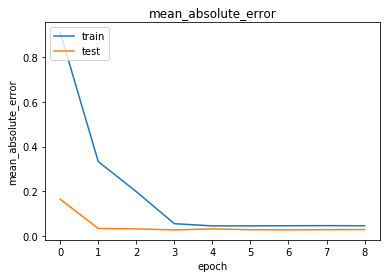

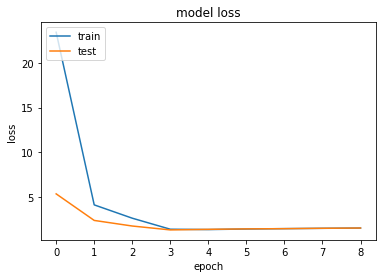

In [43]:
import matplotlib.pyplot as plt
import numpy

# summarize history for mean_absolute_error
plt.plot(mlp_fit.history['mean_absolute_error'])
plt.plot(mlp_fit.history['val_mean_absolute_error'])
plt.title('mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(mlp_fit.history['loss'])
plt.plot(mlp_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [44]:
modelo = mlp

In [45]:
# You can only iterate through a result from `get_prediction_days()` once
# so be careful not to lose it once you start iterating.
days = env.get_prediction_days()

In [46]:
import pandas as pd


def make_predictions_keras (market_obs_df, news_obs_df, predictions_template_df):
    X,_,_ = format_data(market_obs_df, news_obs_df) #cuando usemos news format_data(market_obs_df, news_obs_df)
    X = scaler.transform(X)
    preds = modelo.predict(X).ravel()
    return pd.DataFrame({'assetCode': predictions_template_df['assetCode'], 'confidenceValue': preds })
    

In [47]:
 modelo.predict(X_scale_test).ravel()

array([ 0.00554497,  0.00696957,  0.00723218,  0.00381172,  0.00662435,
        0.00533578,  0.00385603,  0.00646144,  0.00613509,  0.00516023,
        0.0083011 ,  0.00611598,  0.00498286,  0.0087769 ,  0.00503913,
        0.00624171,  0.00758362,  0.0054498 ,  0.00631946,  0.00557508,
        0.00539606,  0.00642024,  0.00560538,  0.00342856,  0.00699954,
        0.00547388,  0.01012593,  0.00597826,  0.00615016,  0.00818842,
        0.0056015 ,  0.00618701,  0.00789126,  0.00482787,  0.00520342,
        0.01208157,  0.00473744,  0.00625412,  0.00719929,  0.00562795,
        0.00853085,  0.01090288,  0.00699531,  0.00657202,  0.0096522 ,
        0.0025937 ,  0.00684941,  0.01036343,  0.00457708,  0.00661452,
        0.00811926,  0.00620147,  0.00591862,  0.0056887 ,  0.00499195,
        0.00694432,  0.00850613,  0.00504545,  0.0079727 ,  0.00638036,
        0.00571437,  0.00776546,  0.00679389,  0.00482194,  0.00431689,
        0.00648481,  0.00683946,  0.01066683,  0.00609307,  0.00

In [48]:
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    predictions_df = make_predictions_keras(market_obs_df, news_obs_df, predictions_template_df) 
    env.predict(predictions_df)
print('Done!')

Done!


In [ ]:
env.write_submission_file()

# FIN PRACTICA

In [ ]:
# We've got a submission file!
import os
print([filename for filename in os.listdir('.') if '.csv' in filename])